<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ, 2024</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Библиотека sklearn и классификация с помощью KNN</b></h1>

## Описание домашнего задания

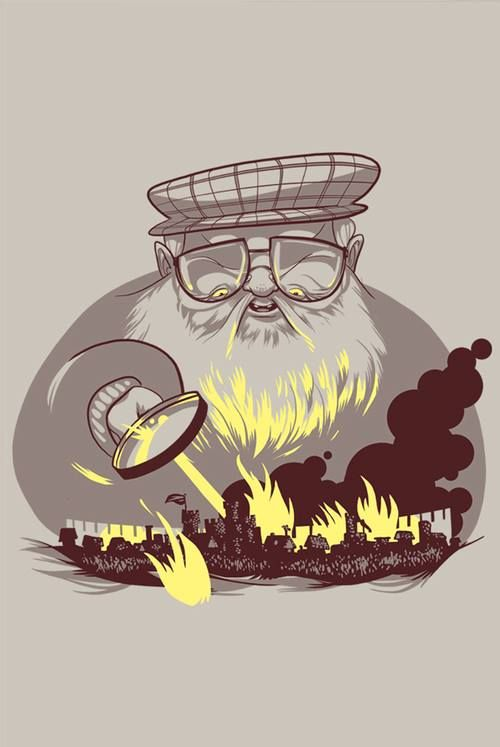

В данном задании вы будете работать с датасетом о персонажах из вселенной Игры Престолов [A Wiki of Ice and Fire](http://awoiaf.westeros.org/). Вам предстоит предсказать, кто из персонажей умрет, а кто останется вживых.



Описание данных:

* **name**: Имя персонажа

* **Title**: Социальный статус или знатность

* **House**: Дом, к которому принадлежит персонаж

* **Culture**: Социальная группа, к которой принадлежит персонаж

* **book1/2/3/4/5**: Появление персонажа в книге

* **Is noble**: Знатность персонажа, основанное на титуле

* **Age**: Отсчет времени: 305 AC

* **male**: Мужчина или женщина

* **dateOfBirth**: дата рождения

* **Spouse**: Имя супруги\а персонажа

* **Father**: Имя отца персонажа

* **Mother**: Имя матери персонажа

* **Heir**: Имя наследника персонажа

* **Is married**: Represents whether the character is married

* **Is spouse alive**: Represents whether character's spouse is alive

* **Is mother alive:** Жива ли мать персонажа

* **Is heir alive:** Жив ли наследник персонажа

* **Is father alive:** Указывает, жив ли отец персонажа

* **Number dead relations:** Количество умерших персонажей, с которыми персонаж связан

* **Popularity score:** Количество внутренних входящих и исходящих ссылок на страницу персонажей в вики http://awoiaf.westeros.org

Целевая переменная:
* **isAlive**: жив ли персонаж в книге

Оценивание:

Баллы считаются следующим образом:

1) $1.00 \geqslant score \geqslant 0.84$ --- 5 баллов

2) $0.84 > score \geqslant 0.77$ --- 4 балла

3) $0.77 > score \geqslant 0.70$ --- 3 балла

4) $0.70 > score \geqslant 0.65$ --- 2 балла

5) $0.65 > score \geqslant 0.6$ --- 1 балл

6) $0.60 > score$ --- 0 баллов

## Часть 1. Анализ и предобработка данных

Здесь вам необходимо сделать все шаги, которые обсуждались в первой части семинара.
* Предобработка данных
  * Обработка пропущенных данных
  * Создание новых признаков
  * Удаление ненужных столбцов
* Анализ данных
  * Анализ целевой переменной
  * Анализ признаков
  * Анализ влияния признаков на целевую переменную
* Подготовка данных для обучения модели

Загружаем датасет

In [46]:
!gdown 1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3 # test dataset
!gdown 1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v # train dataset
!mv game_of_thrones_test.csv test.csv
!mv game_of_thrones_train.csv train.csv

**Задание 1.1.** Импортируйте библиотеки pandas, matplotlib, seaborn

**Задание 1.2.** Загрузите датасет в Pandas DataFrame при помощи функции `read_csv`. Вместо дефолтных наименований строк `0,1,...`, при помощи параметра `index_col`, сделайте значения колонки `S.No` наименованиями строк:

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import accuracy

In [48]:
train = pd.read_csv('train.csv', index_col = 'S.No')
train.columns.tolist()
cats = train.select_dtypes(include = 'object').columns.tolist()
nums = train.select_dtypes(exclude = 'object').columns.tolist()
pd.DataFrame([cats, nums], index = ['cats', 'nums']).T

,cats,nums
0,name,male
1,title,dateOfBirth
2,culture,book1
3,mother,book2
4,father,book3
5,heir,book4
6,house,book5
7,spouse,isAliveMother
8,None,isAliveFather
9,None,isAliveHeir


**Задание 1.3.** Предобработка (очистка) данных.

Проанализируйте, если в колонках NaN значения. Если есть, примите решение, как вы их будете обрабатывать. Вы можете либо удалить их, либо заполнить каким нибудь значением (например, медианой или модой).

In [49]:
nans_df = pd.concat([train.isna().sum(),
                    train.isna().sum() / train.shape[0] * 100],
                    axis = 1,
                    keys = ['Nans count', 'Nans percentage'])
cols_to_remove = nans_df[nans_df['Nans percentage'] > 90].index.tolist()
print(nans_df, cols_to_remove)
def remove_nans(data): return data.drop(cols_to_remove, axis = 1)

                  Nans count  Nans percentage
name                       0         0.000000
title                    840        53.949904
male                       0         0.000000
culture                 1069        68.657675
dateOfBirth             1278        82.080925
mother                  1539        98.843931
father                  1535        98.587026
heir                    1536        98.651252
house                    381        24.470135
spouse                  1357        87.154785
book1                      0         0.000000
book2                      0         0.000000
book3                      0         0.000000
book4                      0         0.000000
book5                      0         0.000000
isAliveMother           1539        98.843931
isAliveFather           1535        98.587026
isAliveHeir             1536        98.651252
isAliveSpouse           1357        87.154785
isMarried                  0         0.000000
isNoble                    0      

**Задание 1.4.** Создайте новые признаки.
* Создайте признак isPopular. У вас есть в таблице признак popularity score, поставьте какой то порог, например, 0.5, и пусть те персонажи, у которых popularity score меньше 0.5, непопулярны, т.е. isPopular = 0. Если же выше 0.5, тогда пусть isPopular=1.
* Создайте признак boolDeadRelations. Давайте упростим признак numDeadRelations, и просто поделим людей на тех, у кого были хоть какие то отношения с мертвыми персонажами, т.е. numDeadRelations > 0, и те, у которых не было, т.е. numDeadRelations = 0.
* Упростите признак culture, объединив схожие названия в один.


In [50]:
# Подсказка
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

In [51]:
def simplify(x):
    for key, value in cult.items():
        if x in value:
            return key.lower()
    return x
def generate_features(df):
    df['isPopular'] = (df['popularity'] > 0.5).astype(int)
    df['boolDeadRelations'] = (train['numDeadRelations'] > 0).astype(int)
    df['culture'] = df['culture'].str.lower()
    df['culture'] = df['culture'].apply(simplify)
    return df

**Задание 1.5.** Проанализируйте, какие столбцы являются существенными и влияют на предсказание, а какие нет. Удалите ненужные столбцы по вашему мнению.

In [52]:
corr_map = (abs(remove_nans(train).select_dtypes(exclude = 'object').corr()['isAlive']) < 0.05)
# вычленяем совсем слабые по корреляции признаки
print(corr_map.sum())

weak_corr = corr_map[corr_map].index.tolist()
print(weak_corr)
def drop_weak_corr(df): return df.drop(weak_corr, axis = 1)

3
['book3', 'book5', 'isMarried']


**Задание 1.6.** Проанализируйте целевую переменную. Посмотрите, является ли она категориальной или количественной. Так как мы говорим о задаче классификации, проанализируйте является ли датасет сбалансированным по классам или нет.

In [53]:
# явный дисбаланс классов
train.isAlive.value_counts()

isAlive
1    1212
0     345
Name: count, dtype: int64

**Задание 1.7.** Проанализируйте признаки.
  * Обработайте категориальные признаки и переведите их в числа. Можете выбрать любой кодировщик.
  * Проанализируйте количественные признаки. Есть ли корреляция между признаками?

In [54]:
def remove_name(df) : return df.drop('name', axis = 1)
remove_nans(train).select_dtypes('object')
# на этом этапе мне кажется, что нет никакого смысла пытаться изменить заполнять или кодировать признаки с 80% пропусками
# после удаления пропусков остаётся только имя как категориальный признак, но оно уникально и "ниачомнигаварит"
# TODO: достать дом из имени

,name,title,culture,house,spouse
S.No,,,,,
1,Viserys II Targaryen,NaN,NaN,NaN,NaN
2,Walder Frey,Lord of the Crossing,Rivermen,House Frey,Perra Royce
3,Addison Hill,Ser,NaN,House Swyft,NaN
4,Aemma Arryn,Queen,NaN,House Arryn,Viserys I Targaryen
5,Sylva Santagar,Greenstone,Dornish,House Santagar,Eldon Estermont
...,...,...,...,...,...
1553,Marwyn,Archmaester,NaN,NaN,NaN
1554,Masha Heddle,NaN,NaN,NaN,NaN
1555,Matthos Seaworth,NaN,NaN,House Seaworth,NaN


**Задание 1.8.** Проанализируйте влияние признаков на целевую переменную.

**Задание 1.9.** Создайте переменные `X`, которая будет хранить только значения признаков, и `y`, которая будет хранить только значения целевой переменной.

**Задание 1.10.** Разделите датасет на train и test часть при помощи функции `train_test_split`
y = 


In [55]:
def preprocess(df):
    df = remove_nans(df)
    df = generate_features(df)
    df = drop_weak_corr(df)
    df = remove_name(df)
    print(f"Данные преобразованны!")
    return df 

In [56]:
# !pip install --quiet category-encoders

In [57]:
from category_encoders import TargetEncoder
df = preprocess(train)
encoder = TargetEncoder()
cats = df.select_dtypes('object').columns.tolist()
df[cats] = encoder.fit_transform(df[cats], df['isAlive'])
df = df.fillna(df.mean())
print(f'Количество пропусков после обработки: {df.isna().sum().sum()}')

Данные преобразованны!
Количество пропусков после обработки: 0


In [58]:
df.head(3)

,title,male,culture,dateOfBirth,house,spouse,book1,book2,book4,isAliveSpouse,isNoble,age,numDeadRelations,popularity,isAlive,isPopular,boolDeadRelations
S.No,,,,,,,,,,,,,,,,,
1,0.800000,1,0.781104,247.551971,0.803150,0.786293,0,0,0,0.79,0,35.290323,11,0.605351,0,1,1
2,0.807249,1,0.757330,208.000000,0.898755,0.807249,1,1,1,1.00,1,97.000000,1,0.896321,1,1,1
3,0.774510,1,0.781104,247.551971,0.825875,0.786293,0,0,1,0.79,1,35.290323,0,0.267559,1,0,0


In [59]:
from sklearn.model_selection import train_test_split
X, y = df.drop('isAlive', axis = 1), df['isAlive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Часть 2. Обучение моделей

В данной части домашнего задания, мы хотим научиться обучать модели для задачи классификации на наших данных.

**Задание 2.1.** Импортируйте следующие модели из библиотеки `sklearn`
* LogisticRegression
* RandomForestClassifier
* AdaBoostClassifier
* GaussianProcessClassifier
* GaussianNB
* KNeighborsClassifier
* SVC
* DecisionTreeClassifier


В качестве примера, импортируем модель `LogisticRegression`

Импортируйте остальные модели из библиотеки `sklearn`. Чтобы понять как это сделать, воспользуйтесь официальный документацией `sklearn` $→$ [тык](https://scikit-learn.org/dev/user_guide.html). По ключевому названию модели, вы сможете найти необходимую информацию о том, как можно импортировать модель из библиотеки.

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB

**Задание 2.2.** Обучите модель и сделайте предсказание на тестовой выборке

В качестве примера, обучим модель `LogisticRegression` и сделаем на ней предсказания на тестовой выборке.

In [61]:
import warnings 
warnings.filterwarnings('ignore')
# Шаг 1. создание модели
logistic_regression = LogisticRegression(C=1)
# Шаг 2. обучение модели
logistic_regression.fit(X_train, y_train)
# Шаг 3. Предсказание на тестовых данных
y_pred = logistic_regression.predict(X_test)

In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.782051282051282

In [63]:
# Шаг 1. создание модели
models = {
    'decision_tree': DecisionTreeClassifier(), 
    'kneighbours  ': KNeighborsClassifier(),
    'svc          ' : SVC(),
    'random_forest': RandomForestClassifier(),
    'ada_boost    ': AdaBoostClassifier(),
    'gaussian     ': GaussianProcessClassifier(),
    'native_bayes ': GaussianNB(),
}

# Шаг 2. обучениеjмодели
# Шаг 3. Предсказание на тестовых данных
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    print(f'Model {name}\t accuracy: \t\t{accuracy:.4f}')


Model decision_tree	 accuracy: 		0.8526
Model kneighbours  	 accuracy: 		0.8301
Model svc          	 accuracy: 		0.8045
Model random_forest	 accuracy: 		0.8814
Model ada_boost    	 accuracy: 		0.8397
Model gaussian     	 accuracy: 		0.8237
Model native_bayes 	 accuracy: 		0.8141


Аналогичным образом обучите остальные модели и сделайте предсказания на тестовой выборке.

## Часть 3. Оцените качество моделей

Вам необходимо познакомиться с метриками задачи классификации из sklearn. Оцените все модели и выберите лучшую по метрике качества Accuracy.

С метриками классификации вы можете ознакомиться в [Yandex ML Book](https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii).

Для простоты в данном домашнем задании мы будем работать с самой базовой метрикой для задачи классификации - accuracy.

**Задание 3.1.** Вам необходимо посчитать метрику для всех моделей и выбрать лучшую модель.

Сначала импортируем необходимую функцию из библиотеки sklearn для подсчета accuracy.

In [64]:
from sklearn.metrics import accuracy_score
# уже посчитал выше))

В качестве примера, посчитаем метрику accuracy для модели `LogisticRegression`

In [65]:
y_pred = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : %.4f" % accuracy)

Accuracy : 0.7821


Аналогичным образом посчитайте метрику accuracy для остальных моделей

In [66]:
print("Accuracy : %.4f" % accuracy)

Accuracy : 0.7821


Выберите лучшую модель.

### Файл `submission.csv`

Вам нужно вместо значений в `submission.csv` файле в колонке `isAlive`, подставить свои предсказания и сохранить измененный файл.

In [67]:
!gdown 1M14conWjAW2QLoyCXbHEAy8bql2f99eF

Downloading...
From: https://drive.google.com/uc?id=1M14conWjAW2QLoyCXbHEAy8bql2f99eF
To: /home/r/c/dls1/submission.csv
100%|██████████████████████████████████████| 2.74k/2.74k [00:00<00:00, 5.97MB/s]


In [68]:
submission = pd.read_csv("./submission.csv", index_col='S.No')

In [69]:
models['random_forest'].fit(X, y)
test = pd.read_csv("./test.csv", index_col='S.No')
test_df = preprocess(test)

cats = test_df.select_dtypes('object').columns
test_df[cats] = encoder.transform(test_df[cats])
test_df = test_df.fillna(test_df.mean())

submission['isAlive'] = models['random_forest'].predict(test_df)
submission.to_csv("./new_submission.csv", index=False)
# stepik accuracy 0.7429305912596401

Данные преобразованны!


Как сохранить измененный Pandas DataFrame в csv файл:

# Это было baseline решение 
# теперь попробуем оптимизировать по-максимуму


In [78]:
!pip install --quiet xgboost catboost

In [141]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
train = pd.read_csv('./train.csv', index_col='S.No')
test  = pd.read_csv("./test.csv",  index_col='S.No')

X, y = train.drop('isAlive', axis = 1), train['isAlive']
cats = X.select_dtypes('object').columns.tolist()
nums = X.select_dtypes('number').columns.tolist()
X[nums] = X[nums].fillna(X[nums].mean())
X[cats] = X[cats].fillna('nan')
test[nums] = test[nums].fillna(test[nums].mean())
test[cats] = test[cats].fillna('nan')


new_models = {
    'catboost': CatBoostClassifier(iterations = 1000,
                                   verbose = 250,
                                   eval_metric = 'Accuracy',
                                   cat_features = cats),
    'xgboost': XGBClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=5,
        enable_categorical = True),
}

In [113]:
new_models['catboost'].fit(X, y)
catboost_pred = new_models['catboost'].predict(test)
submission['isAlive'] = catboost_pred
submission.to_csv("./catboost_submission.csv", index=False)
# stepik accuracy 0.7532133676092545

Learning rate set to 0.012446
0:	learn: 0.8150289	total: 5.33ms	remaining: 5.32s
250:	learn: 0.8362235	total: 1.03s	remaining: 3.07s
500:	learn: 0.8561336	total: 3.79s	remaining: 3.77s
750:	learn: 0.8798972	total: 10.9s	remaining: 3.62s
999:	learn: 0.8998073	total: 16.4s	remaining: 0us


In [147]:
train = pd.read_csv('./train.csv', index_col='S.No')
test  = pd.read_csv("./test.csv",  index_col='S.No')
encoder = TargetEncoder()

df = preprocess(train)
cats = df.select_dtypes('object').columns
df[cats] = encoder.fit_transform(df[cats], df['isAlive'])
df = df.fillna(df.mean())

test_df = preprocess(test)
cats = test_df.select_dtypes('object').columns
test_df[cats] = encoder.transform(test_df[cats])
test_df = test_df.fillna(test_df.mean())


X, y = df.drop('isAlive', axis = 1), df['isAlive']
print(f'Количество пропусков после обработки: {df.isna().sum().sum()} {test_df.isna().sum().sum()}')

Данные преобразованны!
Данные преобразованны!
Количество пропусков после обработки: 0 389


In [148]:
test_df['boolDeadRelations'].isna().sum() / len(test_df['boolDeadRelations'])
# как мы видим, в тестовой выборке не осталось вообще ненан значений для столбца 
X.drop('boolDeadRelations', axis = 1, inplace = True)
test_df.drop('boolDeadRelations', axis = 1, inplace = True)
print(f'Количество пропусков после обработки: {df.isna().sum().sum()} {test_df.isna().sum().sum()}')

Количество пропусков после обработки: 0 0


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [155]:

new_models['xgboost'].fit(X, y)
xgboost_pred = new_models['xgboost'].predict(test_df)
submission['isAlive'] = xgboost_pred
submission.to_csv("./xgboost_submission.csv", index=False)
# stepik accuracy 0.699228791773779

**теперь хочу попробовать препроцессить данные и поперебирать гипры с оптюной**

In [156]:
!pip install --quiet optuna

In [193]:
import optuna
from sklearn.preprocessing import StandardScaler
#заново получаем данные
train = pd.read_csv('./train.csv', index_col='S.No')
test  = pd.read_csv("./test.csv",  index_col='S.No')
train_df = preprocess(train)
test_df = preprocess(test)

# заново енкодим категориальные признаки (этот метод очень хорошо себя показал
encoder = TargetEncoder()
cats = train_df.select_dtypes('object').columns.tolist()
train_df[cats] = encoder.fit_transform(train_df[cats], train_df['isAlive'])
test_df[cats] = encoder.transform(test_df[cats])


#заново сплитим трейн и тест
X, y = train_df.drop('isAlive', axis = 1), train_df['isAlive']
X[X.columns] = StandardScaler().fit_transform(X)
test_df[test_df.columns] = StandardScaler().fit_transform(test_df)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    stratify=y)


def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'early_stopping_rounds': 200,
        'n_estimators': 10000,  # Большое значение для работы early stopping
        'enable_categorical': True,
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'tree_method': 'hist',
        'random_state': 42,
    }
    
    model = XGBClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
    )
    
    # Сохраняем лучшую итерацию
    trial.set_user_attr('best_iteration', model.best_iteration)
    
    # Предсказание с использованием лучшей итерации
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Можно увеличить количество trials

best_trial = study.best_trial
print(f"Best accuracy: {best_trial.value:.4f}")
print("Best params:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

# Формирование финальных параметров
best_params = best_trial.params.copy()
best_params['n_estimators'] = best_trial.user_attrs['best_iteration'] + 1
best_params.update({
    'enable_categorical': True,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'tree_method': 'hist',
    'random_state': 42
})

[I 2025-02-19 17:03:29,083] A new study created in memory with name: no-name-60ddd809-08b0-4cb1-852a-6f43aba3768b


Данные преобразованны!
Данные преобразованны!


[I 2025-02-19 17:03:53,282] Trial 0 finished with value: 0.8782051282051282 and parameters: {'learning_rate': 0.002101985714536204, 'max_depth': 3, 'subsample': 0.7305962553294253, 'colsample_bytree': 0.6835929205478801, 'gamma': 0.049190661761242704, 'reg_alpha': 2.4274969685752033, 'reg_lambda': 0.002413825352093065, 'min_child_weight': 1}. Best is trial 0 with value: 0.8782051282051282.
[I 2025-02-19 17:03:55,983] Trial 1 finished with value: 0.8717948717948718 and parameters: {'learning_rate': 0.012533174135707544, 'max_depth': 8, 'subsample': 0.7793729557325819, 'colsample_bytree': 0.7437898102515259, 'gamma': 0.44705716732870016, 'reg_alpha': 0.03416507798434897, 'reg_lambda': 0.002035997671057739, 'min_child_weight': 10}. Best is trial 0 with value: 0.8782051282051282.
[I 2025-02-19 17:04:04,602] Trial 2 finished with value: 0.8717948717948718 and parameters: {'learning_rate': 0.001279976771079698, 'max_depth': 9, 'subsample': 0.6324749779783818, 'colsample_bytree': 0.7494483781

Best accuracy: 0.9199
Best params:
learning_rate: 0.0739306843200614
max_depth: 3
subsample: 0.9585894636968579
colsample_bytree: 0.8080887182295206
gamma: 0.08973161120029687
reg_alpha: 0.010309479899132489
reg_lambda: 0.057725641012305734
min_child_weight: 2


In [194]:
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8080887182295206, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None,
              gamma=0.08973161120029687, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0739306843200614,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=303, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [195]:
optuna_preds = xgb_model.predict(test_df)
submission['isAlive'] = optuna_preds
submission.to_csv("./xgboost_optuna_submission.csv", index=False)
# stepik accuracy 0.7249357326478149

In [210]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 5000),  # Количество итераций
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 16),  # Глубина дерева
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),  # Регуляризация L2
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),  # Случайная сила
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Температура бэггинга
        'border_count': trial.suggest_int('border_count', 32, 255),  # Количество границ для числовых признаков
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),  # Минимальное количество данных в листе
        'verbose': False,  # Отключение вывода логов 
        'eval_metric': 'Accuracy',  # Используем accuracy как метрику
        'random_state': 42,
        'early_stopping_rounds': 10,  # Ранняя остановка через 10 итераций
    }
    
    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
    )
    
    # Сохраняем лучшую итерацию
    trial.set_user_attr('best_iteration', model.best_iteration_)
    
    # Предсказание с использованием лучшей итерации
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)  # Можно увеличить количество trials

best_trial = study.best_trial
print(f"Best accuracy: {best_trial.value:.4f}")
print("Best params:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

# Формирование финальных параметров
best_params = best_trial.params.copy()
best_params.update({
    'eval_metric': 'Accuracy',
    'random_state': 42
})

[I 2025-02-19 17:22:24,169] A new study created in memory with name: no-name-bd164f50-0d9e-4e38-ac14-be31c1d275d2
[I 2025-02-19 17:22:46,449] Trial 0 finished with value: 0.8782051282051282 and parameters: {'iterations': 2634, 'learning_rate': 0.0013945331427213617, 'depth': 16, 'l2_leaf_reg': 0.13688474123654318, 'random_strength': 0.0014236632672238736, 'bagging_temperature': 0.5728896520874033, 'border_count': 109, 'min_data_in_leaf': 14}. Best is trial 0 with value: 0.8782051282051282.
[I 2025-02-19 17:22:46,571] Trial 1 finished with value: 0.8814102564102564 and parameters: {'iterations': 3502, 'learning_rate': 0.25848707635454404, 'depth': 10, 'l2_leaf_reg': 0.20114066525810398, 'random_strength': 0.13478434483152568, 'bagging_temperature': 0.8193722924791681, 'border_count': 187, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.8814102564102564.
[I 2025-02-19 17:22:47,389] Trial 2 finished with value: 0.8814102564102564 and parameters: {'iterations': 569, 'learning_rate':

Best accuracy: 0.9135
Best params:
iterations: 757
learning_rate: 0.17833943121273835
depth: 13
l2_leaf_reg: 2.2601963036228265
random_strength: 0.3496321736645846
bagging_temperature: 0.1036783253869403
border_count: 255
min_data_in_leaf: 61


In [211]:
catboost_model = CatBoostClassifier(**best_params)
catboost_model.fit(X, y)

0:	learn: 0.8702633	total: 59ms	remaining: 44.6s
1:	learn: 0.8721901	total: 70ms	remaining: 26.4s
2:	learn: 0.8901734	total: 130ms	remaining: 32.8s
3:	learn: 0.9023764	total: 188ms	remaining: 35.5s
4:	learn: 0.9145793	total: 245ms	remaining: 36.9s
5:	learn: 0.9287091	total: 301ms	remaining: 37.7s
6:	learn: 0.9293513	total: 352ms	remaining: 37.7s
7:	learn: 0.9344894	total: 401ms	remaining: 37.5s
8:	learn: 0.9344894	total: 449ms	remaining: 37.3s
9:	learn: 0.9364162	total: 494ms	remaining: 36.9s
10:	learn: 0.9409120	total: 547ms	remaining: 37.1s
11:	learn: 0.9409120	total: 595ms	remaining: 36.9s
12:	learn: 0.9454078	total: 642ms	remaining: 36.8s
13:	learn: 0.9454078	total: 687ms	remaining: 36.5s
14:	learn: 0.9454078	total: 732ms	remaining: 36.2s
15:	learn: 0.9473346	total: 779ms	remaining: 36.1s
16:	learn: 0.9473346	total: 827ms	remaining: 36s
17:	learn: 0.9511882	total: 871ms	remaining: 35.8s
18:	learn: 0.9505459	total: 917ms	remaining: 35.6s
19:	learn: 0.9531150	total: 967ms	remaining: 

In [212]:
optuna_preds = catboost_model.predict(test_df)
submission['isAlive'] = optuna_preds
submission.to_csv("./catboost_optuna_submission.csv", index=False)
# stepik accuracy 0.6195372750642674